# TF1 assessement - Analytics Engineer

### On commence par lire les données depuis les fichiers CSV 

In [1]:
import pandas as pd

In [2]:
contents = pd.read_csv('data/CONTENTS.csv', encoding='utf-8')
user_events = pd.read_csv('data/USER_EVENTS.csv', parse_dates=['PLAY_START', 'PLAY_END'], encoding='utf-8')
users = pd.read_csv('data/USERS.csv', parse_dates=['USER_CREATED_DATE'], encoding='utf-8')

In [4]:
contents.head(3)

,CONTENT_ID,CONTENT_DURATION,CONTENT_PROGRAM_ID,CONTENT_PROGRAM_NAME,CONTENT_TYPE
0,c46819a0-07aa-4330-b095-d265993be4ab,0,1f68f713-fd53-4353-9209-3bf1e2e119d2,Profilage,Série
1,69dbc04e-cfaa-4526-a64d-7701b8f42077,0,a3b85c07-7001-4b31-9dc0-80b241b1063b,La bataille des clans,Jeu
2,5e506981-0124-42c1-a321-f023770c9696,182,16d805c1-8c62-4e9b-bc72-0b504478ebf3,Football - EURO,Evènement sportif


In [5]:
contents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CONTENT_ID            3955 non-null   object
 1   CONTENT_DURATION      3955 non-null   int64 
 2   CONTENT_PROGRAM_ID    3955 non-null   object
 3   CONTENT_PROGRAM_NAME  3955 non-null   object
 4   CONTENT_TYPE          3955 non-null   object
dtypes: int64(1), object(4)
memory usage: 154.6+ KB


In [6]:
user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   EVENT_DATE   32000 non-null  object        
 1   DEVICE       32000 non-null  object        
 2   OS           31990 non-null  object        
 3   IS_LOGGEDIN  32000 non-null  bool          
 4   USER_ID      32000 non-null  object        
 5   CONTENT_ID   32000 non-null  object        
 6   PLAY_ID      32000 non-null  object        
 7   PLAY_START   32000 non-null  datetime64[ns]
 8   PLAY_END     32000 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), object(6)
memory usage: 2.0+ MB


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15993 entries, 0 to 15992
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   USER_ID            15993 non-null  object        
 1   USER_CREATED_DATE  15993 non-null  datetime64[ns]
 2   USER_AGE           15990 non-null  float64       
 3   USER_GENDER        15991 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 499.9+ KB


### Maintenant, on crée la base de données Sqlite et on y insère les données 

In [8]:
import sqlite3

conn = sqlite3.connect('tf1.db')

In [9]:
contents.to_sql('contents', conn, if_exists='replace', index=False)
user_events.to_sql('user_events', conn, if_exists='replace', index=False)
users.to_sql('users', conn, if_exists='replace', index=False)

15993

### On test par quelques requêtes simples

In [10]:
pd.read_sql(""" 
    select * 
    from user_events
    limit 2
""", conn)

,EVENT_DATE,DEVICE,OS,IS_LOGGEDIN,USER_ID,CONTENT_ID,PLAY_ID,PLAY_START,PLAY_END
0,2024-06-17,smart-tv,amazon,1,02449dbb096ff022496bfd3a4063804cee173694,222efbcd-40e1-4bd8-885f-06d28d71b5c4,d478b4d071424e33d39605b9eda50637f448852bdaaaa8...,2024-06-17 11:52:56.708000,2024-06-17 11:52:57.708000
1,2024-06-17,smart-tv,google,1,8d4ab68f0bcebbbadf1a3c85ce9eb3f5b84d66b2,65b6ebcd-749e-4ad4-81fc-394a57ae8635,ab4821ae7238adb9b0518d9a0ebe9fe232c80d271aca77...,2024-06-17 05:54:55.937000,2024-06-17 05:54:56.937000


In [11]:
pd.read_sql('''
SELECT COUNT(*) AS total_users
FROM users
            ''', conn)

,total_users
0,15993


In [12]:
users.shape[0]

15993

C'est cohérent!

### On passe vers les questions!

### 1.	Affichez le volume de lectures par jour, puis par programme trié par ordre décroissant

In [13]:
# le volume de lectures par jour
lectures_par_jour = pd.read_sql(""" 
    select EVENT_DATE as jour,
            count(PLAY_ID) as volume_lectures
    from user_events
    group by EVENT_DATE
    order by volume_lectures desc
""", conn)
lectures_par_jour

,jour,volume_lectures
0,2024-06-23,4000
1,2024-06-22,4000
2,2024-06-21,4000
3,2024-06-20,4000
4,2024-06-19,4000
5,2024-06-18,4000
6,2024-06-17,4000
7,2024-06-16,4000


In [14]:
all([4000*8, user_events.shape[0], lectures_par_jour['volume_lectures'].sum()]), 4000*8

(True, 32000)

C'est cohérent!

In [15]:
# le volume de lectures par programme
lectures_par_programme = pd.read_sql("""
        select CONTENT_PROGRAM_NAME programme,
            count(PLAY_ID) as volume_lectures
            from user_events ue INNER JOIN contents c
            ON ue.CONTENT_ID = c.CONTENT_ID
            Group by CONTENT_PROGRAM_NAME
            order by volume_lectures Desc
""", conn)
lectures_par_programme

,programme,volume_lectures
0,Ici tout commence,6981
1,Demain nous appartient,5892
2,"Plus belle la vie, encore plus belle",2714
3,SYNCHRO,556
4,Football - EURO,420
...,...,...
406,Agatha Christie : ils étaient dix,1
407,A la recherche de l’assassin de mon père,1
408,A Perfect Enemy,1
409,64 rue du Zoo,1


In [16]:
# Combiner les deux
lectures_par_jour_prog = pd.read_sql("""
        select EVENT_DATE jour, 
            CONTENT_PROGRAM_NAME programme,
            count(PLAY_ID) as volume_lectures
            from user_events ue INNER JOIN contents c
            ON ue.CONTENT_ID = c.CONTENT_ID
            Group by EVENT_DATE, CONTENT_PROGRAM_NAME
            order by volume_lectures Desc
""", conn)
lectures_par_jour_prog

,jour,programme,volume_lectures
0,2024-06-20,Ici tout commence,1499
1,2024-06-20,Demain nous appartient,1250
2,2024-06-19,Ici tout commence,1052
3,2024-06-21,Ici tout commence,939
4,2024-06-22,Ici tout commence,840
...,...,...,...
1209,2024-06-23,Une si longue nuit,1
1210,2024-06-23,Vanquish : une nuit de vengeance,1
1211,2024-06-23,Vengeance sur le campus,1
1212,2024-06-23,"Vidéos sexy, lycéennes en danger",1


Une visualisation serait un plus!

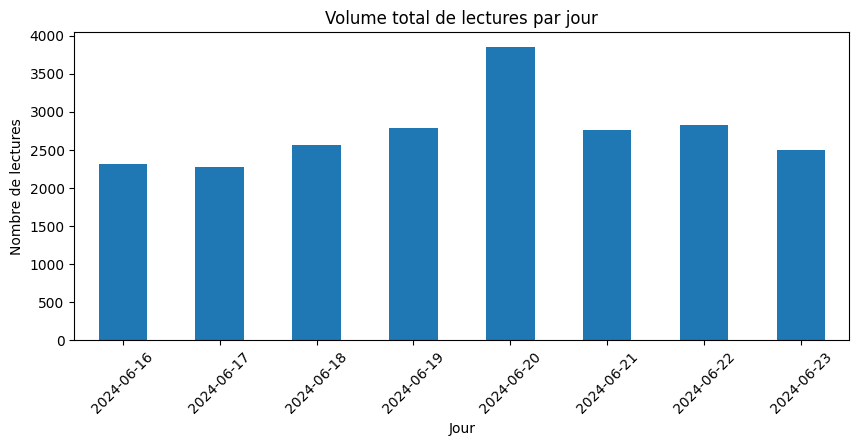

In [17]:
import matplotlib.pyplot as plt

lectures_par_jour_prog.groupby("jour")["volume_lectures"].sum().plot(kind="bar", figsize=(10,4))
plt.title("Volume total de lectures par jour")
plt.xlabel("Jour")
plt.ylabel("Nombre de lectures")
plt.xticks(rotation=45)
plt.show()


### 2.	Affichez le TOP 10 des programmes où le temps passé cumulé est le plus important

In [18]:
top10_programmes = pd.read_sql(""" 
    select CONTENT_PROGRAM_NAME programme, 
            sum(strftime('%s',PLAY_END) - strftime('%s',PLAY_START)) as duree
    from user_events ue inner join contents c
    ON ue.CONTENT_ID = c.CONTENT_ID
    where PLAY_END > PLAY_START
    group by CONTENT_PROGRAM_NAME
    order by duree DESC
    limit 10
""", conn)
top10_programmes

,programme,duree
0,Ici tout commence,636190
1,Demain nous appartient,448650
2,"Plus belle la vie, encore plus belle",227328
3,Star Academy,27637
4,Podcast MYTF1,21330
5,HPI,17424
6,SYNCHRO,12788
7,Football - EURO,9850
8,Secret story,7577
9,Les experts : Miami,7144


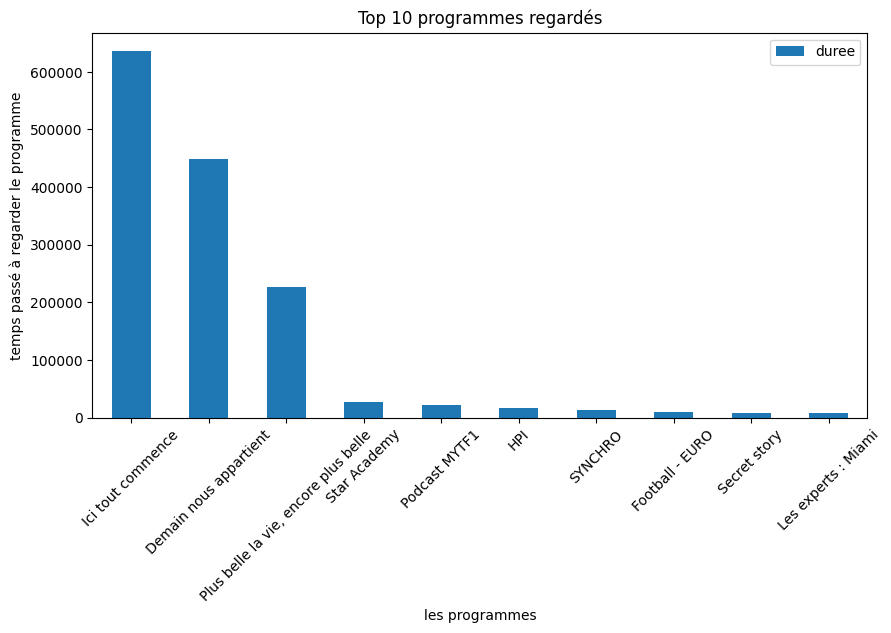

In [19]:
top10_programmes.groupby('programme').sum().sort_values('duree', ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Top 10 programmes regardés')
plt.xlabel('les programmes')
plt.ylabel('temps passé à regarder le programme')
plt.xticks(rotation=45)
plt.show()

### 3.	A l’aide d’une Window Function, affichez pour chaque journée le programme ayant le temps passé par vidéo le plus important

In [20]:
temps_par_programme = pd.read_sql("""                          
        with cte as (
                select 
                        ue.EVENT_DATE journee,
                        c.CONTENT_PROGRAM_NAME programme,
                        strftime('%s', PLAY_END)- strftime('%s', PLAY_START) as temps_regarde
                from user_events ue INNER JOIN contents c
                ON ue.CONTENT_ID=c.CONTENT_ID
                where PLAY_END>PLAY_START
        ),
        ranked_programme as (
                select 
                        journee, programme, temps_regarde,
                        ROW_NUMBER() over(PARTITION BY journee ORDER BY temps_regarde DESC) as rnk                        
                from cte
        )

        select journee, programme, temps_regarde from ranked_programme 
                where rnk=1
""", conn)
temps_par_programme

,journee,programme,temps_regarde
0,2024-06-16,"Joséphine, ange gardien",3632
1,2024-06-17,HPI,4115
2,2024-06-18,Ici tout commence,10970
3,2024-06-19,Sous le soleil,3016
4,2024-06-20,Demain nous appartient,6086
5,2024-06-21,Miraculous - Les aventures de Ladybug et Chat ...,1499
6,2024-06-22,Un village français,4078
7,2024-06-23,Les experts : Miami,5705


### 4. Verifiez la présence des programmes fortement consommés sur la home page de TF1

In [21]:
import requests
from bs4 import BeautifulSoup

In [22]:
# fonction pour trouver le programme le plus regardé en nombre de fois
def get_top_program_for_date(date_str, db_conn) -> str:

    query = """
    select
        c.CONTENT_PROGRAM_NAME
    From
        USER_EVENTS e
    INNER JOIN
        CONTENTS c ON e.CONTENT_ID = c.CONTENT_ID
    WHERE
        e.EVENT_DATE = ?
    GROUP by
        c.CONTENT_PROGRAM_NAME
    ORDER BY
        COUNT(e.PLAY_ID) DESC
    LIMIT 1;
    """
    try:
        top_program_df = pd.read_sql_query(query, db_conn, params=(date_str,))
        if top_program_df.empty:
            return str()
        else:
            return top_program_df.iloc[0]['CONTENT_PROGRAM_NAME']
    except Exception as e:
        print(f"Erreur SQL: {e}")
        return str()

In [23]:
get_top_program_for_date('2024-06-16',conn), get_top_program_for_date('2024-09-16',conn)

('Demain nous appartient', '')

On focalise sur le site TF1 maintenant, pour comprendre sa structrure et comment trouver les programme 

In [24]:
url = "https://www.tf1.fr/"

response = requests.get(url, timeout=10)
response.raise_for_status() 
print(response)
soup = BeautifulSoup(response.content, 'html.parser')


<Response [200]>


In [ ]:
soup.find('a', class_='kkdklds')

In [25]:
# on remarque que chaque programme afficher dans la home page est dans un <a> avec la class: -outline-offset-2
programmes_list= [a.get_text() for a in soup.find_all('a', class_='-outline-offset-2')]

In [27]:
programmes_list[:10]

['Star Academy',
 'La Villa des Cœurs Brisés',
 'Montmartre',
 'Ghosts : Fantômes à la maison',
 "Zack Snyder's Justice League",
 'Charmed',
 'Pourris gâtés',
 'Hôtel Transylvanie',
 'The Sister',
 'Mask Singer']

on crée la fonction `is_program_present`

In [28]:
def is_program_present(date_str, db_conn):
    
    # 1- Trouver le programme le plus vu
    program_name = get_top_program_for_date(date_str, db_conn)
    
    print(f"Date: {date_str}")
    if not program_name:
        print(f"Aucun programme trouvé pour la date {date_str}")
        return False
        
    print(f"Programme le plus vu dans la base de donnée: '{program_name}'")

    # 2- Scrapper la homepage de TF1+
    url = "https://www.tf1.fr/"
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status() 
        
        # 3- Parser avec BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        programmes_list= [a.get_text() for a in soup.find_all('a', class_='-outline-offset-2')]

        
        if program_name in programmes_list:
            print(f"Programme trouvé!!! '{program_name}' est présent sur la Home Page)")
            return True
        else:
            print(f"Programme NON trouvé!!! '{program_name}' n'est pas présent sur la Home Page")
            return False
            
    except requests.exceptions.RequestException as e:
        print(f"Erreur lors du scraping de {url}: {e}")
        return False
    except Exception as e:
        print(f"Une erreur inattendue est survenue: {e}")
        return False


In [29]:
is_program_present('2024-06-16', conn), is_program_present('2024-06-20', conn), is_program_present('2024-09-16', conn), 

Date: 2024-06-16
Programme le plus vu dans la base de donnée: 'Demain nous appartient'
Programme trouvé!!! 'Demain nous appartient' est présent sur la Home Page)
Date: 2024-06-20
Programme le plus vu dans la base de donnée: 'Ici tout commence'
Programme trouvé!!! 'Ici tout commence' est présent sur la Home Page)
Date: 2024-09-16
Aucun programme trouvé pour la date 2024-09-16


(True, True, False)

### 5. Table de visualization des données

In [42]:
user_events.columns

Index(['EVENT_DATE', 'DEVICE', 'OS', 'IS_LOGGEDIN', 'USER_ID', 'CONTENT_ID',
       'PLAY_ID', 'PLAY_START', 'PLAY_END'],
      dtype='object')

In [ ]:
user_events['OS'].unique() # pour savoir comment faire avec les OS avec versions

array(['amazon', 'google', 'skyworthdigital', 'samsung', 'iOS 17.x',
       'expressluck', 'hisense', 'lg', 'my', 'Android 8.x', 'tcl',
       'apple', 'inspur', 'sony', 'Android 13.x', 'xiaomi',
       'Android 11.x', 'Android 14.x', 'iOS 16.x', 'Android 10.x',
       'Android 12.x', 'vestel', 'mtc', 'Windows 10', 'xgimi', 'konka',
       'iOS 15.x', 'tpv', 'sdmc', 'fengmi', 'other', 'askey', 'Android',
       'scbc', 'philips', 'Android 9.x', 'changhong', 'macOS 10.15.x',
       'chengdu', 'skyworth', 'nvidia', 'sharp', 'sei', 'mediatek',
       'android-7.1.1 7.x', 'hkc', 'vs', 'allwinner', 'zte',
       'android-10 10.x', 'haier', 'onn', 'ktc', 'droidlogic', 'smarttv',
       'panasonic', 'smartphone', 'm043', 'arris', 'iOS 14.x',
       'Chrome OS 125.x', 'formuler', 'android-8.1.0 8.x', 'jiuzhou',
       'OS X 10.11.x', 'Linux', 'android-7.0 7.x', 'macOS 10.13.x',
       'sagemcom', 'android-6.0.1 6.x', 'iOS 18.x', 'android-13 13.x',
       'android-12 12.x', 'macOS 10.12.x', 'iO

In [47]:
pd.read_sql("""

select
            EVENT_DATE,
            PLAY_ID,
            IS_LOGGEDIN,
            strftime('%s', PLAY_END)- strftime('%s', PLAY_START) as duree_regardee,
            DEVICE,
            CASE
                WHEN LOWER(OS) LIKE '%android%' THEN 'Android'
                WHEN LOWER(OS) LIKE '%ios%' THEN 'iOS'
                WHEN LOWER(OS) LIKE '%ipados%' THEN 'iPadOS'
                WHEN LOWER(OS) LIKE '%macos%' THEN 'macOS'
                WHEN LOWER(OS) LIKE '%os x%' THEN 'macOS'
                WHEN LOWER(OS) LIKE '%chrome os%' THEN 'Chrome OS'
                WHEN LOWER(OS) LIKE '%windows%' THEN 'Windows'
                WHEN LOWER(OS) LIKE '%linux%' THEN 'Linux'
                ELSE OS
            END AS OS,
            c.CONTENT_DURATION duree_contenu

FROM user_events ue 
            LEFT JOIN contents c
            ON ue.CONTENT_ID=c.CONTENT_ID 


""", conn)

,EVENT_DATE,PLAY_ID,IS_LOGGEDIN,duree_regardee,DEVICE,OS,duree_contenu
0,2024-06-17,d478b4d071424e33d39605b9eda50637f448852bdaaaa8...,1,1,smart-tv,amazon,NaN
1,2024-06-17,ab4821ae7238adb9b0518d9a0ebe9fe232c80d271aca77...,1,1,smart-tv,google,5745.0
2,2024-06-17,2e536cecd0df16e610a03f11b0d7f6efd502f05cecc3ce...,1,20,smart-tv,amazon,NaN
3,2024-06-17,edafb519e7ec52e6c5252d48afd81da24908bb53e55974...,1,1,smart-tv,skyworthdigital,NaN
4,2024-06-17,f43a60cef21672b60201aeb3354a99b1ba58b62db21e61...,1,2,smart-tv,google,NaN
...,...,...,...,...,...,...,...
32117,2024-06-22,7afbd31f1ddc0f16e950413478682b9efaf250121086cf...,0,164,Mobile Phone,Android,93.0
32118,2024-06-22,17b7964c191ae571e4e29891325b7913cca809c1bea47c...,0,63,Mobile Phone,iOS,156.0
32119,2024-06-22,8bf3c47702e1afbce1d11608cf97c5ba27f41a25b09412...,0,238,Mobile Phone,Android,238.0
32120,2024-06-22,252d094cbf2ba389e767b5f37c36301e087fb5ab0060ae...,0,13,Mobile Phone,iOS,93.0


In [54]:
table_final_agg = pd.read_sql("""
with cte as (
    select
                EVENT_DATE,
                PLAY_ID,
                IS_LOGGEDIN,
                strftime('%s', PLAY_END)- strftime('%s', PLAY_START) as duree_regardee,
                DEVICE,
                CASE
                    WHEN LOWER(OS) LIKE '%android%' THEN 'Android'
                    WHEN LOWER(OS) LIKE '%ios%' THEN 'iOS'
                    WHEN LOWER(OS) LIKE '%ipados%' THEN 'iPadOS'
                    WHEN LOWER(OS) LIKE '%macos%' THEN 'macOS'
                    WHEN LOWER(OS) LIKE '%os x%' THEN 'macOS'
                    WHEN LOWER(OS) LIKE '%chrome os%' THEN 'Chrome OS'
                    WHEN LOWER(OS) LIKE '%windows%' THEN 'Windows'
                    WHEN LOWER(OS) LIKE '%linux%' THEN 'Linux'
                    ELSE OS
                END AS OS,
                c.CONTENT_DURATION duree_contenu

    FROM user_events ue 
                LEFT JOIN contents c
                ON ue.CONTENT_ID=c.CONTENT_ID 
    WHERE PLAY_END > PLAY_START
)

select 
            EVENT_DATE date, DEVICE, OS, IS_LOGGEDIN,
            SUM(CASE WHEN
                duree_regardee>=90 then 1 ELSE 0 END) as videos_regardes_sup90,
            SUM(CASE WHEN duree_contenu>=90 then 1 else 0 end) as videos_contenu_sup90,
            COUNT(PLAY_ID) as total_videos_vues,
            SUM(IS_LOGGEDIN) as total_vues_loguees

from cte
group by EVENT_DATE, DEVICE, OS, IS_LOGGEDIN
order by date

""", conn)

table_final_agg

,date,DEVICE,OS,IS_LOGGEDIN,videos_regardes_sup90,videos_contenu_sup90,total_videos_vues,total_vues_loguees
0,2024-06-16,Desktop,Android,0,1,1,1,0
1,2024-06-16,Desktop,Chrome OS,0,1,1,1,0
2,2024-06-16,Desktop,Chrome OS,1,1,1,1,1
3,2024-06-16,Desktop,Linux,0,2,4,4,0
4,2024-06-16,Desktop,Linux,1,1,1,1,1
...,...,...,...,...,...,...,...,...
665,2024-06-23,smart-tv,xiaomi,0,4,11,23,0
666,2024-06-23,smart-tv,xiaomi,1,8,35,87,87
667,2024-06-23,smart-tv,zte,0,0,0,1,0
668,2024-06-23,smart-tv,zte,1,0,1,1,1


export de la table finale vers la base de données Sqlite

In [55]:
table_final_agg.to_sql('table_agg', conn, if_exists='replace', index=False)

670